In [1]:
from importlib import reload  # Not needed in Python 2
import warnings
from datetime import datetime
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import sys
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm, trange
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import gc
import glob
import torch
from torch.utils.data import Dataset, DataLoader,RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
import warnings
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix,f1_score, accuracy_score,precision_score, recall_score
                             
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit,GroupKFold
from transformers import PreTrainedModel,RobertaConfig,RobertaModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel,AutoConfig
from transformers import DataCollatorWithPadding,get_linear_schedule_with_warmup


def seed_all(seed_value):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True  
        torch.backends.cudnn.benchmark = False  
        
RANDOM_SEED=567
seed_all(RANDOM_SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_LABEL=4
L = False
DEBUG = False
MAX_LEN = 400
EPOCHS=5
EVALAFTER=1000
PSEUDO=True

PLAIN=False

BATCH_SIZE=16


if DEBUG:
    DEBUG_DATA_SIZE=25
    EPOCHS=2
    
if(L):
    IN_BASEPATH="../../input/"
    TRAIN_BATCH_SIZE = 1
    VALID_BATCH_SIZE = 1
    print("l")
else:
    IN_BASEPATH="../input/inputeg/"
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 8
    print("esdata")
USE_SCHEDULER=True
USE_AML=False



if L:
    IN_BASEPATH="../../input/"
else:
    IN_BASEPATH="../input/inputeg/"

traindata_path=IN_BASEPATH+"1trainingTP.tsv"
testdata_path=IN_BASEPATH+"1testTP.tsv"

trainCompress_path=IN_BASEPATH+"3TrainCompressManualClean.tsv"
trainConcat_path=IN_BASEPATH+"3TrainConcatManualClean.tsv"

testConcat_path=IN_BASEPATH+"4TestConcat.tsv"

if PSEUDO:
    valConcat_path=IN_BASEPATH+"4ValConcat.tsv"
else:
    valConcat_path=IN_BASEPATH+"4ValConcatManualClean.tsv"

MODEL_NAME='microsoft/deberta-base'
# MODEL_NAME='roberta-base'
# MODEL_NAME='xlnet-base-cased'
# MODEL_NAME='albert-base-v2'#
OUT_BASEPATH=f"output/{MODEL_NAME.split('/')[-1]}model"



CV_DICT1 = {
            1: ['Form10k_65','Form10k_44','Form10k_74','Form10k_01'],
            2:['Form10k_61','Form10k_22','Form10k_14','Form10k_23'],
            3:['Form10k_63','Form10k_25','Form10k_34','Form10k_37']
            }

CV_DICT2 = {
            1: ['Form10k_55','Form10k_64','Form10k_60','Form10k_59'],
            2:['Form10k_57','Form10k_47','Form10k_12','Form10k_73'],
}

CV_DICT = CV_DICT1
# if not PLAIN:
#     CV_DICT = CV_DICT2
    
    

try:
     os.makedirs(OUT_BASEPATH)
except:
     pass
    
    
SEPCIAL_TOKEN=['[NSEP]']
# SEPCIAL_TOKEN=None

    
WARMUP=50


       
        
# xlnet-base-cased
# microsoft/deberta-base'
# 'albert-base-v2'

# 123 deberta_pseudo
# 45 albert_pseudo
# 678 xlnet_pseudo
# 901 albert
# 2021 deberta

if "deberta" in MODEL_NAME:
# https://deepai.org/publication/deberta-decoding-enhanced-bert-with-disentangled-attention
    RANDOM_SEED=123
    WARMUP=50
    LEARNING_RATE = 1.5e-5
elif "albert" in MODEL_NAME:
# https://arxiv.org/pdf/1909.11942.pdf
    RANDOM_SEED=45
    WARMUP=320
    LEARNING_RATE = 1e-05
elif "xlnet-base-cased":
# https://arxiv.org/pdf/1906.08237.pdf
    RANDOM_SEED=678
    LEARNING_RATE = 2e-5
    
ACCUMULATION_STEPS=int(BATCH_SIZE/TRAIN_BATCH_SIZE)
print("ACCUMULATION_STEPS :",ACCUMULATION_STEPS)

# LEARNING_RATE=1e-05
LEARNING_RATE=1.5e-5

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len,labelexist=True):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.sentence
        self.labelexist= labelexist
        if self.labelexist:
            self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, index):

        if DEBUG:
            inputs = self.tokenizer(
            self.sentence[index], # /lower()
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True)
        else:
            inputs = self.tokenizer(
            self.sentence[index], # /lower()
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        ) 
                
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        if self.labelexist:
            return {
                'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'labels': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),

            }
        
def doconfusion_matrix(traintarget,trainpreds,testtarget,testpreds):
    df_cm_train = pd.DataFrame(confusion_matrix(traintarget,trainpreds))
    df_cm_test = pd.DataFrame(confusion_matrix(testtarget,testpreds))
    df_cm_train.index.name='Actual'
    df_cm_train.columns.name='Predicted'
    sns.set(font_scale=1.4)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.heatmap(df_cm_train,annot=True,annot_kws={"size":15}, ax=ax1)
    sns.heatmap(df_cm_test,annot=True,annot_kws={"size":15}, ax=ax2)
    plt.show()
    
    
def doconfusion_matrix_one(traintarget,trainpreds):
    plt.figure(figsize=(8, 6), dpi=80)
    df_cm_train = pd.DataFrame(confusion_matrix(traintarget,trainpreds))
    df_cm_train.index.name='Actual'
    df_cm_train.columns.name='Predicted'
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm_train,annot=True,annot_kws={"size":15})
    plt.show()
print(MODEL_NAME)
print(RANDOM_SEED)
print(LEARNING_RATE)
print("SPEICAL_TOKEN",SEPCIAL_TOKEN)

esdata
ACCUMULATION_STEPS : 2
microsoft/deberta-base
123
1.5e-05
SPEICAL_TOKEN ['[NSEP]']


In [2]:
def validate(model):
    model.eval()
    batchtargets=[]
    batchoutputs=[]
    total_loss=0
    with torch.no_grad():
        for i,batch in enumerate((val_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
        
            outputs = model(**batch)
            loss,logits=outputs[:2]
            if USE_AML:
                total_loss=total_loss +(loss.item()/ACCUMULATION_STEPS)
            else:
                total_loss=total_loss +(loss.item())
            outputs=logits.cpu().detach().numpy()    
            outputs=np.argmax(outputs, axis=1)
            batchoutputs.extend(outputs)

            targets=batch['labels'].cpu().detach().numpy()
            batchtargets.extend(targets)
            del outputs,loss,logits,batch,targets
            _ = gc.collect()
            torch.cuda.empty_cache()
    return batchtargets,batchoutputs,(total_loss/len(batchtargets))



def loadmodel(modelname,modelpath=None,specialtoken=None):
    tokenizer = AutoTokenizer.from_pretrained(modelname)
    model = AutoModelForSequenceClassification.from_pretrained(modelname, num_labels=NUM_LABEL)

#     special_tokens_dict = {'additional_special_tokens': ['[NSEP]']}
    
    if specialtoken is not None:
        print("added new token: ",specialtoken)
        special_tokens_dict = {'additional_special_tokens': specialtoken}
        num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
        model.resize_token_embeddings(len(tokenizer))

    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
    model.to(device)
    
    if modelpath is not None:
        print("loading model checkpoint...")
        checkpoint = torch.load(modelpath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_dict'])
    
    #tmp%%
    print(SEPCIAL_TOKEN,NUM_LABEL,LEARNING_RATE)
    return tokenizer,model,optimizer


def addlabelToken(df):
    customtoken=""
    if df.label==0:
        customtoken="[Other]"
    elif df.label==1:
        customtoken="[Green]"
    elif df.label==2:
        customtoken="[Environmental]"
    elif df.label==3:
        customtoken="[Social]"
    return customtoken+df.sentence

def addTitle(df):
    newsentence= " ".join(str(df.title).split()[:25])+" [NSEP] "+df.sentence
    return newsentence

def replaceSpacetoDuplicatetitle(df):
    global duplicatetitles
    return df.title.apply(lambda x:"" if "".join([w[0] for w in x if w[0].isalnum()]).lower() in duplicatetitles else x)


In [3]:
# get duplicate title
df=pd.read_csv(traindata_path, sep='\t')
df['ttl']=df.title.apply(lambda x:"".join([w[0] for w in x if w[0].isalnum()]).lower())
df0title=df[df.label==0].ttl.value_counts().index.tolist()
df123title=df[df.label!=0].ttl.value_counts().index.tolist()
duplicatetitles=set(df0title) & set(df123title)

del df

column=['sid', 'sentence', 'html_id', 'label','title']

#make VALDF
VALDF=pd.read_csv(valConcat_path, sep='\t')
VALDF.astype({"label": int})

# read train data
cptrain=pd.read_csv(trainCompress_path, sep='\t')
cctrain=pd.read_csv(trainConcat_path, sep='\t')
testdata=pd.read_csv(testdata_path, sep='\t')

if SEPCIAL_TOKEN is not None:
    print("st")
    # preprocess title and sentence
    cptrain['title']=replaceSpacetoDuplicatetitle(cptrain)
    cctrain['title']=replaceSpacetoDuplicatetitle(cctrain)
    cptrain['sentence']=cptrain.apply(addTitle,axis=1)
    cctrain['sentence']=cctrain.apply(addTitle,axis=1)
    testdata['title']=replaceSpacetoDuplicatetitle(testdata)
    testdata['sentence']=testdata.apply(addTitle,axis=1)
    VALDF['title']=replaceSpacetoDuplicatetitle(VALDF)
    VALDF['sentence']=VALDF.apply(addTitle,axis=1)


#make train0 for TRAINDF
cptrain0=cptrain[cptrain.label==0].sample(frac=1,random_state = RANDOM_SEED)[:1000]
cctrain0=cctrain[cctrain.label==0].sample(frac=1,random_state = RANDOM_SEED)[:8000]
train0=pd.concat([cptrain0[column],cctrain0[column]])
train0.astype({"label": int})

#make train123 for TRAINDF
cptrain123=cptrain[cptrain.label!=0]
cctrain123=cctrain[cctrain.label!=0]
train123=pd.concat([cptrain123[column],cctrain123[column]])
train123.astype({"label": int})


print("train123.label.value_counts :")
print(train123.label.value_counts())


st
train123.label.value_counts :
3    4760
2    1015
1     390
Name: label, dtype: int64


In [4]:

def loadData(fold):
    train0L = train0[~train0['html_id'].isin(CV_DICT[fold])]
    train123L = train123[~train123['html_id'].isin(CV_DICT[fold])]
    traindatagp=[]
    train0SampleSize=len(train123L[train123L.label==3])
    for i in range(EPOCHS):
        t0=train0L.sample(train0SampleSize,random_state = RANDOM_SEED+i)
        trainAll=pd.concat([train123L,t0]).sample(frac=1)
        trainAll.drop_duplicates(subset=['sentence'],inplace=True)
        trainAll.dropna(inplace=True)
        trainAll.reset_index(drop=True,inplace=True)
        print(f"{i}:")
        print(trainAll.label.value_counts())
        traindatagp.append(trainAll.reset_index(drop=True))
        print("------------")
    
    valdata=VALDF[VALDF['html_id'].isin(CV_DICT[fold])]
    if PSEUDO:
        valdata.drop_duplicates(subset=['sentence'],inplace=True)
    valdata0=valdata[valdata.label==0].sample(frac=1,random_state = RANDOM_SEED)[:len((valdata[valdata.label==3].index))*2]
    valdata123=valdata[valdata.label!=0]
    valdata=pd.concat([valdata0,valdata123])
    valdata=valdata.sort_values(['html_id', 'sid'], ascending=[True, True])
    valdata.reset_index(drop=True,inplace=True)

    display("len(traindatagp) :",len(traindatagp) )
    
    print("VALDATASET")
    print(valdata.label.value_counts())
    display(valdata.head(3))
    return traindatagp,valdata

traindatagp,valdata=loadData(2)
i=0
traindatalen=0
for td in traindatagp:
    traindatalen=traindatalen+len(td)
    print(td.shape)
    td.to_csv(f"{OUT_BASEPATH}/{i}train_tmp.tsv",sep='\t')
    i=i+1
valdata.to_csv(f"{OUT_BASEPATH}/val_tmp.tsv",sep='\t')
print(traindatalen)

0:
0    3648
3    2998
2     829
1     333
Name: label, dtype: int64
------------
1:
0    3670
3    3000
2     829
1     333
Name: label, dtype: int64
------------
2:
0    3643
3    2999
2     829
1     333
Name: label, dtype: int64
------------
3:
0    3646
3    3000
2     829
1     333
Name: label, dtype: int64
------------
4:
0    3657
3    2999
2     829
1     333
Name: label, dtype: int64
------------


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

5

VALDATASET
0    874
3    437
2     16
1      3
Name: label, dtype: int64


(7808, 5)
(7832, 5)
(7804, 5)
(7808, 5)
(7818, 5)
39070


Epoches Count : 5
USE_AML  False
microsoft/deberta-base
validation data -> 1: ['Form10k_65', 'Form10k_44', 'Form10k_74', 'Form10k_01'] 


Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
0:
0    3728
3    3056
2     817
1     333
Name: label, dtype: int64
------------
1:
0    3713
3    3055
2     817
1     333
Name: label, dtype: int64
------------
2:
0    3727
3    3056
2     817
1     333
Name: label, dtype: int64
------------
3:
0    3728
3    3055
2     817
1     333
Name: label, dtype: int64
------------
4:
0    3711
3    3056
2     817
1     333
Name: label, dtype: int64
------------


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

5

VALDATASET
0    770
3    385
2     22
1      5
Name: label, dtype: int64


Max len :400
Size of the whole VAL dataset :1182
VAL Loader : batchsize 8  :148
Size of the whole TRAIN dataset :7934
TRAIN Loader :batchsize 8  :992
Validate after evey : 330 iterations
<<<<<<  Epoch: 1/5 OF CV: 1  >>>>>>


 10%|█         | 100/992 [01:01<09:32,  1.56it/s]

lr:0.00001500000000000000


 20%|██        | 200/992 [02:03<08:27,  1.56it/s]

lr:0.00001425000000000000


 30%|███       | 300/992 [03:05<09:08,  1.26it/s]

lr:0.00001353750000000000


 33%|███▎      | 330/992 [03:55<1:48:57,  9.88s/it]

f1 score: 0.8793309663661013
best_trainloss: 0.06396444527940316
best_valoss: 0.044732383199433234


 40%|████      | 400/992 [04:38<06:12,  1.59it/s]

lr:0.00001286062500000000


 50%|█████     | 500/992 [05:40<05:06,  1.61it/s]

lr:0.00001221759375000000


 60%|██████    | 600/992 [06:43<03:43,  1.76it/s]

lr:0.00001160671406250000


 71%|███████   | 700/992 [08:13<03:12,  1.52it/s]

lr:0.00001102637835937500


 81%|████████  | 800/992 [09:16<02:05,  1.52it/s]

lr:0.00001047505944140625


 91%|█████████ | 900/992 [10:17<00:56,  1.63it/s]

lr:0.00000995130646933593


100%|██████████| 992/992 [11:43<00:00,  1.41it/s]


Size of the whole TRAIN dataset :7918
TRAIN Loader :batchsize 8  :990
Validate after evey : 330 iterations
<<<<<<  Epoch: 2/5 OF CV: 1  >>>>>>


 10%|█         | 100/990 [01:00<10:10,  1.46it/s]

lr:0.00000945374114586914


 20%|██        | 200/990 [02:01<07:09,  1.84it/s]

lr:0.00000898105408857568


 30%|███       | 300/990 [03:03<06:42,  1.71it/s]

lr:0.00000853200138414689


 40%|████      | 400/990 [04:34<05:14,  1.88it/s]

lr:0.00000810540131493955


 51%|█████     | 500/990 [05:35<04:38,  1.76it/s]

lr:0.00000770013124919257


 61%|██████    | 600/990 [06:36<03:44,  1.74it/s]

lr:0.00000731512468673294


 71%|███████   | 700/990 [08:06<02:54,  1.66it/s]

lr:0.00000694936845239629


 81%|████████  | 800/990 [09:08<01:47,  1.77it/s]

lr:0.00000660190002977648


 91%|█████████ | 900/990 [10:08<00:52,  1.70it/s]

lr:0.00000627180502828765


100%|██████████| 990/990 [11:32<00:00,  1.43it/s]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.879331,0.044732,0.063964


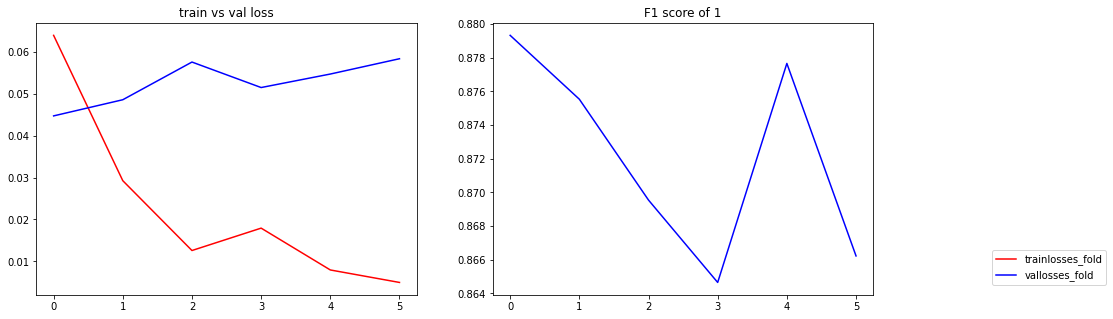

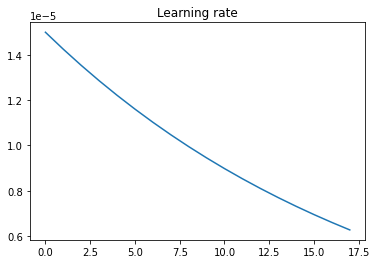

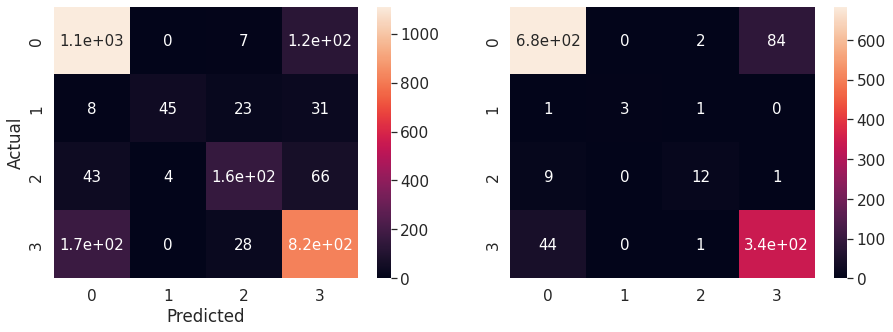

microsoft/deberta-base
validation data -> 2: ['Form10k_61', 'Form10k_22', 'Form10k_14', 'Form10k_23'] 


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
0:
0    3646
3    3000
2     829
1     333
Name: label, dtype: int64
------------
1:
0    3672
3    2998
2     829
1     333
Name: label, dtype: int64
------------
2:
0    3645
3    2997
2     829
1     333
Name: label, dtype: int64
------------
3:
0    3646
3    3000
2     829
1     333
Name: label, dtype: int64
------------
4:
0    3658
3    2998
2     829
1     333
Name: label, dtype: int64
------------


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

5

VALDATASET
0    874
3    437
2     16
1      3
Name: label, dtype: int64


Max len :400
Size of the whole VAL dataset :1330
VAL Loader : batchsize 8  :167
Size of the whole TRAIN dataset :7808
TRAIN Loader :batchsize 8  :976
Validate after evey : 325 iterations
<<<<<<  Epoch: 1/5 OF CV: 2  >>>>>>


 10%|█         | 100/976 [01:03<08:54,  1.64it/s]

lr:0.00001500000000000000


 20%|██        | 200/976 [02:01<07:58,  1.62it/s]

lr:0.00001425000000000000


 31%|███       | 300/976 [03:01<07:33,  1.49it/s]

lr:0.00001353750000000000


 33%|███▎      | 325/976 [03:52<1:58:58, 10.97s/it]

f1 score: 0.8836114521325784
best_trainloss: 0.06712392647249195
best_valoss: 0.04880752711577859


 41%|████      | 400/976 [04:36<05:05,  1.89it/s]

lr:0.00001286062500000000


 51%|█████     | 500/976 [05:36<04:29,  1.77it/s]

lr:0.00001221759375000000


 61%|██████▏   | 600/976 [06:39<04:12,  1.49it/s]

lr:0.00001160671406250000


 67%|██████▋   | 650/976 [07:43<59:30, 10.95s/it]

f1 score: 0.8885946857204822
best_trainloss: 0.031697280402653495
best_valoss: 0.041119004122534754


 72%|███████▏  | 700/976 [08:14<02:39,  1.73it/s]

lr:0.00001102637835937500


 82%|████████▏ | 800/976 [09:18<01:51,  1.58it/s]

lr:0.00001047505944140625


 92%|█████████▏| 900/976 [10:23<00:50,  1.51it/s]

lr:0.00000995130646933593


100%|██████████| 976/976 [11:45<00:00,  1.38it/s]


Size of the whole TRAIN dataset :7832
TRAIN Loader :batchsize 8  :979
Validate after evey : 326 iterations
<<<<<<  Epoch: 2/5 OF CV: 2  >>>>>>


 10%|█         | 100/979 [01:00<08:56,  1.64it/s]

lr:0.00000945374114586914


 20%|██        | 200/979 [02:00<06:55,  1.87it/s]

lr:0.00000898105408857568


 31%|███       | 300/979 [03:04<07:10,  1.58it/s]

lr:0.00000853200138414689


 41%|████      | 400/979 [04:40<06:07,  1.57it/s]

lr:0.00000810540131493955


 51%|█████     | 500/979 [05:44<05:01,  1.59it/s]

lr:0.00000770013124919257


 61%|██████▏   | 600/979 [06:45<03:19,  1.90it/s]

lr:0.00000731512468673294


 72%|███████▏  | 700/979 [08:23<02:50,  1.64it/s]

lr:0.00000694936845239629


 82%|████████▏ | 800/979 [09:24<01:57,  1.52it/s]

lr:0.00000660190002977648


 92%|█████████▏| 900/979 [10:27<00:51,  1.53it/s]

lr:0.00000627180502828765


100%|██████████| 979/979 [11:50<00:00,  1.38it/s]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.879331,0.044732,0.063964
1,2.0,0.888595,0.041119,0.031697


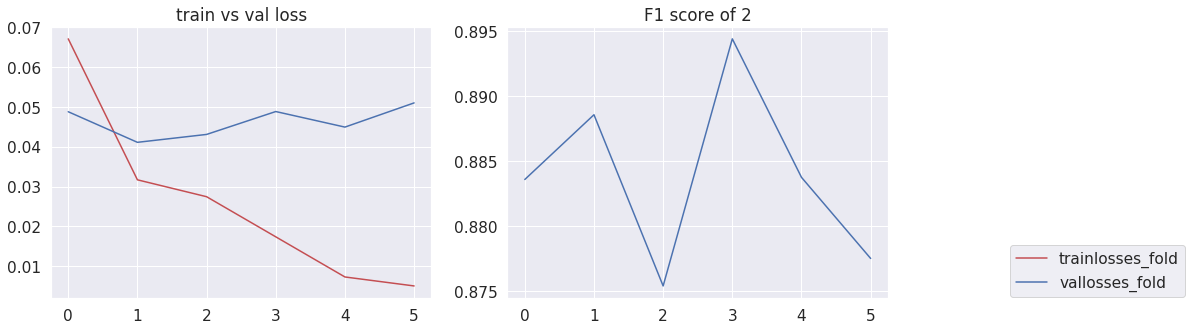

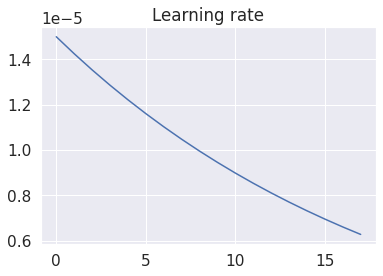

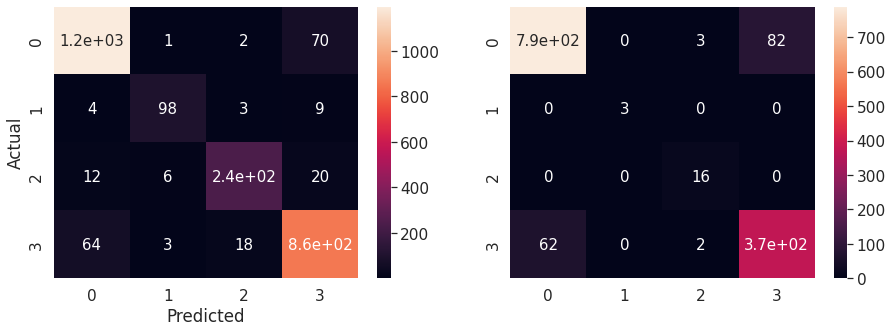

microsoft/deberta-base
validation data -> 3: ['Form10k_63', 'Form10k_25', 'Form10k_34', 'Form10k_37'] 


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
0:
0    3744
3    3101
2     732
1     311
Name: label, dtype: int64
------------
1:
0    3747
3    3101
2     732
1     311
Name: label, dtype: int64
------------
2:
0    3756
3    3101
2     732
1     311
Name: label, dtype: int64
------------
3:
0    3742
3    3102
2     732
1     311
Name: label, dtype: int64
------------
4:
0    3749
3    3101
2     732
1     311
Name: label, dtype: int64
------------


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

5

VALDATASET
0    806
3    403
2     65
1     20
Name: label, dtype: int64


Max len :400
Size of the whole VAL dataset :1294
VAL Loader : batchsize 8  :162
Size of the whole TRAIN dataset :7888
TRAIN Loader :batchsize 8  :986
Validate after evey : 328 iterations
<<<<<<  Epoch: 1/5 OF CV: 3  >>>>>>


 10%|█         | 100/986 [01:05<08:33,  1.73it/s]

lr:0.00001500000000000000


 20%|██        | 200/986 [02:06<07:51,  1.67it/s]

lr:0.00001425000000000000


 30%|███       | 300/986 [03:08<07:17,  1.57it/s]

lr:0.00001353750000000000


 33%|███▎      | 328/986 [03:58<1:52:57, 10.30s/it]

f1 score: 0.8095364042200688
best_trainloss: 0.07453469376693048
best_valoss: 0.06665173319630452


 41%|████      | 400/986 [04:44<05:50,  1.67it/s]

lr:0.00001286062500000000


 51%|█████     | 500/986 [05:45<05:00,  1.62it/s]

lr:0.00001221759375000000


 61%|██████    | 600/986 [06:48<03:58,  1.62it/s]

lr:0.00001160671406250000


 67%|██████▋   | 656/986 [07:56<56:40, 10.30s/it]

f1 score: 0.8482014191602829
best_trainloss: 0.03543420693455207
best_valoss: 0.057696827241094345


 71%|███████   | 700/986 [08:22<03:08,  1.52it/s]

lr:0.00001102637835937500


 81%|████████  | 800/986 [09:23<01:54,  1.62it/s]

lr:0.00001047505944140625


 91%|█████████▏| 900/986 [10:25<00:54,  1.58it/s]

lr:0.00000995130646933593


100%|██████████| 986/986 [11:50<00:00,  1.39it/s]


Size of the whole TRAIN dataset :7891
TRAIN Loader :batchsize 8  :987
Validate after evey : 329 iterations
<<<<<<  Epoch: 2/5 OF CV: 3  >>>>>>


 10%|█         | 100/987 [01:02<10:49,  1.37it/s]

lr:0.00000945374114586914


 20%|██        | 200/987 [02:04<09:15,  1.42it/s]

lr:0.00000898105408857568


 30%|███       | 300/987 [03:08<07:09,  1.60it/s]

lr:0.00000853200138414689


 41%|████      | 400/987 [04:41<06:22,  1.53it/s]

lr:0.00000810540131493955


 51%|█████     | 500/987 [05:43<04:46,  1.70it/s]

lr:0.00000770013124919257


 61%|██████    | 600/987 [06:43<03:43,  1.74it/s]

lr:0.00000731512468673294


 71%|███████   | 700/987 [08:17<02:47,  1.72it/s]

lr:0.00000694936845239629


 81%|████████  | 800/987 [09:21<01:49,  1.71it/s]

lr:0.00000660190002977648


 91%|█████████ | 900/987 [10:23<00:55,  1.57it/s]

lr:0.00000627180502828765


100%|██████████| 987/987 [11:51<00:00,  1.39it/s]


saving


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.879331,0.044732,0.063964
1,2.0,0.888595,0.041119,0.031697
2,3.0,0.848201,0.057697,0.035434


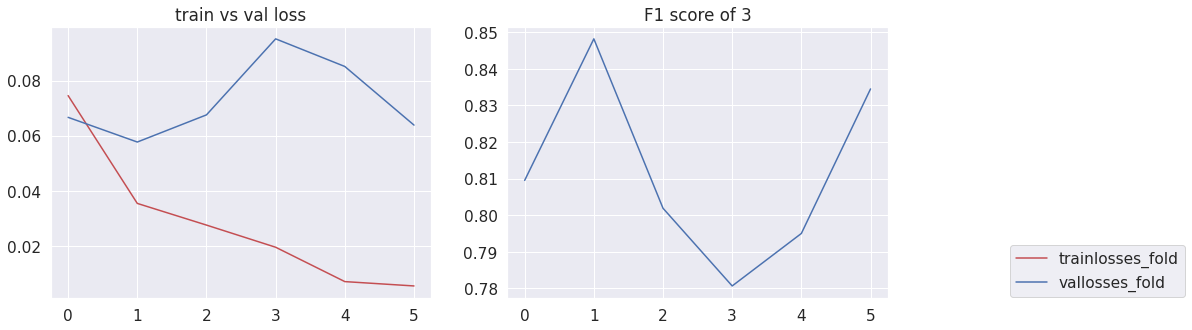

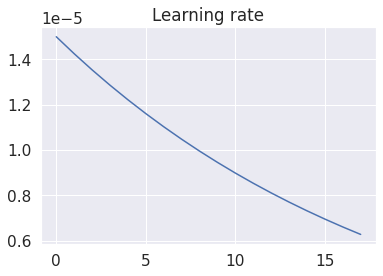

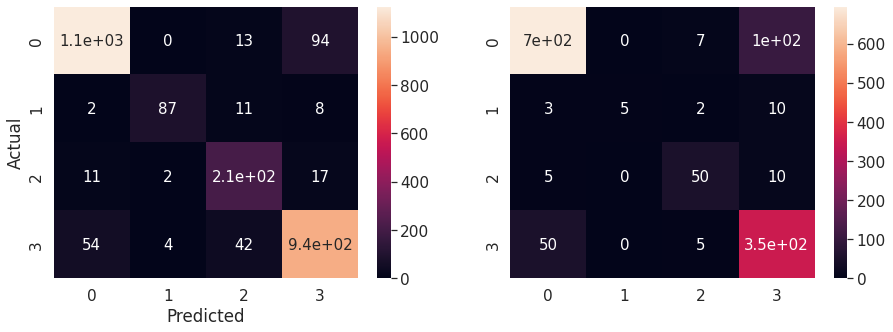

All CV loop finished.
output/deberta-basemodel_2021_11_10-03:43:13_AM
Training finished.
MODELPATH_R : output/deberta-basemodel_2021_11_10-03:43:13_AM


,fold,f1_weighted,vallosses,trainlosses
0,1.0,0.879331,0.044732,0.063964
1,2.0,0.888595,0.041119,0.031697
2,3.0,0.848201,0.057697,0.035434


Model mean cv valloss score 0.047849404854354106
Model mean cv f1 score 0.8720423570822887


In [5]:
print(f"Epoches Count : {EPOCHS}")
print("USE_AML ",USE_AML)
bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses","trainlosses"])
for fold in CV_DICT.keys():
    print(MODEL_NAME)
    print(f'validation data -> {fold}: {CV_DICT[fold]} ')
    tokenizer,model,optimizer= loadmodel(MODEL_NAME,specialtoken=SEPCIAL_TOKEN)
    
    traindatagps,valdata =loadData(fold)
    
    if DEBUG:
        MAX_LEN =400
        train_params = {'batch_size': TRAIN_BATCH_SIZE,
                       'pin_memory': True,
                        'num_workers': 0,
                        'shuffle':True
                        }
    
        val_params = {'batch_size': VALID_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0
                     }
        valdata=valdata[:DEBUG_DATA_SIZE]
    else:
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        train_params = {'batch_size': TRAIN_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0,
                        'collate_fn':data_collator,
                        'shuffle':True
                        }
    
        val_params = {'batch_size': VALID_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0,
                      'collate_fn':data_collator
                        }
        
    valset = CustomDataset(valdata, tokenizer, MAX_LEN)
    val_dataloader = DataLoader(valset, **val_params)
    num_warmup_steps=traindatalen*0.1
    if USE_SCHEDULER:
#         scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    bestscore= None
    le=[]
    vallosses_fold=[]
    trainlosses_fold=[]
    f1_weighted_fold=[]
    
    print(f"Max len :{MAX_LEN}")
    print(f"Size of the whole VAL dataset :{len(val_dataloader.dataset)}")
    print(f"VAL Loader : batchsize {VALID_BATCH_SIZE}  :{len(val_dataloader)}")
    bestCM_train={'target':[],'pred':[]}
    bestCM_val={'target':[],'pred':[]}
    state={}
    scaler=torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS):
        bestlostfound=False
        traindata=traindatagps[epoch]
        if DEBUG:
            traindata=traindata[:DEBUG_DATA_SIZE+10]
        trainset = CustomDataset(traindata, tokenizer, MAX_LEN)
        
        train_dataloader = DataLoader(trainset, **train_params)
        print(f"Size of the whole TRAIN dataset :{len(train_dataloader.dataset)}")
        print(f"TRAIN Loader :batchsize {TRAIN_BATCH_SIZE}  :{len(train_dataloader)}")
        print(f"Validate after evey : {int(len(train_dataloader)/3)} iterations")
        print(f"<<<<<<  Epoch: {epoch+1}/{EPOCHS} OF CV: {fold}  >>>>>>")        
        traintargets=[] # record only best 
        trainpreds=[]  # record only best 
#         trainlosses=[]  # alltrain loss
        total_loss = 0
        model.train()
        optimizer.zero_grad()
        for step,batch in enumerate(tqdm(train_dataloader)):
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            with torch.cuda.amp.autocast():
                outputs = model(**batch)
                loss,logits=outputs[:2]
                
            targets=batch['labels'].cpu().detach().numpy()
            traintargets.extend(targets)
            
            del batch,outputs,targets
            _ = gc.collect()
            torch.cuda.empty_cache()
            
            if USE_AML:
                loss=loss/ACCUMULATION_STEPS

            
            if L== True:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            if USE_AML:
                if (step+1)%ACCUMULATION_STEPS == 0:
                    if L== True:
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        optimizer.step()
                    optimizer.zero_grad()
            else:
                optimizer.step()
                optimizer.zero_grad()
                
           
            total_loss = total_loss + loss.item()
            outputs=logits.cpu().detach().numpy()    
            outputs=np.argmax(outputs, axis=1)
            trainpreds.extend(outputs)
            
            del logits,loss,outputs
            _ = gc.collect()
            torch.cuda.empty_cache()
            
            if USE_SCHEDULER:
                if ((step+1) % 100 == 0 ):
                    print(f"lr:{scheduler.get_last_lr()[0]:.20f}")
                    le.append(scheduler.get_last_lr()[0])
                    scheduler.step()
                

            if ((step+1) % int(len(train_dataloader)/3) == 0 ):
                valtargets,valpreds,valloss=validate(model)
                model.train()
               
                trainlosses_fold.append(total_loss/len(traintargets))
                total_loss=0
                vallosses_fold.append(valloss)
                f1_weighted_fold.append(f1_score(valtargets, valpreds, average='weighted'))
                if bestscore is None or round(bestscore,5) >= round(valloss,5):
                    bestlostfound=True
                    bestscore=valloss
                    state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        'epoch':epoch,
                        'step':step,
                        'f1_weighted':f1_weighted_fold[-1],
                        'trainlosses':trainlosses_fold[-1],
                        'vallosses':vallosses_fold[-1]
                                }

                    best_valpredictions=valpreds
                    bestCM_train['target'] =traintargets
                    bestCM_train['pred'] =trainpreds
                    bestCM_val['target'] =valtargets
                    bestCM_val['pred'] =valpreds   
                    print('f1 score:',f1_weighted_fold[-1])
                    print('best_trainloss:',trainlosses_fold[-1])
                    print('best_valoss:',vallosses_fold[-1])
                    traintargets=[] # record only best 
                    trainpreds=[]  # record only best 
        
                del valtargets,valpreds,valloss
                _ = gc.collect()
                torch.cuda.empty_cache()

        del trainset,train_dataloader,traintargets,trainpreds
        _ = gc.collect()
        torch.cuda.empty_cache()
        if bestlostfound == False:
            break
    print("saving")
    
    fullpathOutput="{}/{}_e{}_v{:.3f}_fold{}"
    fullpathChkpt=fullpathOutput.format(OUT_BASEPATH,MODEL_NAME.split('/')[-1],epoch,state["vallosses"],int(fold))
    
    torch.save(state, fullpathChkpt+".pth")
    bestrecords=bestrecords.append({'fold': int(fold),
                                'f1_weighted': state["f1_weighted"],
                                'vallosses': state["vallosses"],
                                'trainlosses':state["trainlosses"],
                               },
                               ignore_index=True)   
    display(bestrecords)
    

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    
    ax1.plot(trainlosses_fold,'r',label="trainlosses_fold")
    ax1.plot(vallosses_fold,'b',label="vallosses_fold")
    ax1.title.set_text("train vs val loss")
    ax1.legend(loc='center left', bbox_to_anchor=(2.5, 0.1))
    ax2.title.set_text(f"F1 score of {fold}")
    ax2.plot(f1_weighted_fold,'b',label="f1_weighted_fold")
    plt.show()
    if USE_SCHEDULER:
        plt.title("Learning rate")
        x = np.arange(len(le))
        plt.plot(x,le)
        plt.show()
    doconfusion_matrix(bestCM_train['target'],bestCM_train['pred'],bestCM_val['target'],bestCM_val['pred']) 
   
    valdata["predictions"]=best_valpredictions
    valdata.to_csv(fullpathChkpt+".tsv", sep="\t")
    
    del model,optimizer,tokenizer,state,vallosses_fold,valdata,trainlosses_fold,f1_weighted_fold
    scaler
    _ = gc.collect()
    torch.cuda.empty_cache()
    
print("All CV loop finished.")



date = datetime.now().strftime("_%Y_%m_%d-%I:%M:%S_%p")
MODELPATH_R=OUT_BASEPATH+date
print(MODELPATH_R)

print("Training finished.")
os.rename(OUT_BASEPATH,MODELPATH_R)
print("MODELPATH_R :",MODELPATH_R)

display(bestrecords)
print(f"Model mean cv valloss score {bestrecords['vallosses'].mean()}")
print(f"Model mean cv f1 score {bestrecords['f1_weighted'].mean()}")
del bestrecords
_ = gc.collect()
torch.cuda.empty_cache()

In [6]:
le

[1.5e-05,
 1.4249999999999999e-05,
 1.3537499999999999e-05,
 1.2860624999999999e-05,
 1.2217593749999998e-05,
 1.1606714062499997e-05,
 1.1026378359374997e-05,
 1.0475059441406247e-05,
 9.951306469335934e-06,
 9.453741145869136e-06,
 8.981054088575679e-06,
 8.532001384146894e-06,
 8.105401314939548e-06,
 7.70013124919257e-06,
 7.3151246867329415e-06,
 6.949368452396294e-06,
 6.601900029776479e-06,
 6.271805028287655e-06]

#### CHECK CREATED MODEL

In [7]:
#TEST
test=testdata.copy()
bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses"])

for fold in CV_DICT.keys():
    print(fold)
    print(MODEL_NAME)
    
    tokenizer,model,optimizer= loadmodel(MODEL_NAME,specialtoken=SEPCIAL_TOKEN)
    
    if DEBUG:
        MAX_LEN =400
        test_params = {'batch_size': VALID_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0
                     }
        test=test[:DEBUG_DATA_SIZE]
    else:
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        test_params = {'batch_size': VALID_BATCH_SIZE,
                        'pin_memory': True,
                        'num_workers': 0,
                      'collate_fn':data_collator
                        }
    testset = CustomDataset(test, tokenizer, MAX_LEN,labelexist=False)
    
    test_dataloader=DataLoader(testset,**test_params)
    

    modelpath =list(glob.glob(MODELPATH_R+"/"+"*fold{}.pth".format(fold)))[0]
    print(modelpath)
    checkpoint = torch.load(modelpath)

    model.load_state_dict(checkpoint['state_dict'])

    model.eval()

    del modelpath,checkpoint
    torch.cuda.empty_cache()
    
    logitsoutput=[]
    with torch.no_grad():
        for i,batch in enumerate(tqdm(test_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logitsoutput.extend(outputs.logits.cpu().detach().numpy())
            
    test[f'logits{fold}']=logitsoutput
    test[f'predictions{fold}']=test[f'logits{fold}'].apply(lambda x:x.argmax())
    test[f'confidence{fold}']=test[f'logits{fold}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
    del model
    torch.cuda.empty_cache()
    
# fullpathOutput="{}/{}_e{}_v{:.3f}_fold{}"
# fullpathChkpt=fullpathOutput.format(OUT_BASEPATH,MODEL_NAME.split('/')[-1],epoch,state["vallosses"],int(fold))

# fullpathPreds=f"{outputpath}/{modelname.split('/')[-1]}_testpreds.pkl"
# test.to_pickle(fullpathPreds)

torch.save(test,f"{MODEL_NAME.split('/')[-1]}_Testpreds.pkl")
test.to_csv(f"{MODEL_NAME.split('/')[-1]}_Testpreds.tsv", sep="\t",index=False)


# # preds=pd.read_pickle(fullpathPreds)
# logits_col = [col for col in test if col.startswith('logit')]
# test['FNlogit']=sum(test[column].to_numpy() for column in test[logits_col])/len(logits_col)
# test['FNprediction']=test['FNlogit'].apply(lambda x:x.argmax())
# test['FNtop2class']=test['FNlogit'].apply(lambda x:x.argsort()[-2:][::-1])
# test['FNftop2class']=test['FNlogit'].apply(lambda x:x.argsort()[-2:][::-1])
# test['FNconfidences']=test['FNlogit'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
# test['FNtopconf2']=test['FNconfidences'].apply(lambda x:x[x.argsort()[-2:][::-1]])
# test['FNpredconf']=test['FNtopconf2'].apply(lambda x:x[x.argmax()])

# # preds.to_csv("final.tsv", sep="\t",index=False)
# test['FNcondiff']=test['FNtopconf2'].apply(lambda x:x[0]-x[1])
# test.to_csv(f"{MODEL_NAME.split('/')[-1]}_testpredictions.tsv", sep="\t",index=False)

# pred123=test[(test.FNprediction!=0) & (test.FNcondiff>15)& (test.FNpredconf>95)]
# print(pred123.FNprediction.value_counts())
# pred123.to_csv(f"{MODEL_NAME.split('/')[-1]}_pseudolabels.tsv", sep="\t",index=False)

1
microsoft/deberta-base


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
output/deberta-basemodel_2021_11_10-03:43:13_AM/deberta-base_e1_v0.045_fold1.pth


100%|██████████| 3555/3555 [02:14<00:00, 26.52it/s]


2
microsoft/deberta-base


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
output/deberta-basemodel_2021_11_10-03:43:13_AM/deberta-base_e1_v0.041_fold2.pth


100%|██████████| 3555/3555 [02:14<00:00, 26.38it/s]


3
microsoft/deberta-base


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
output/deberta-basemodel_2021_11_10-03:43:13_AM/deberta-base_e1_v0.058_fold3.pth


100%|██████████| 3555/3555 [02:13<00:00, 26.62it/s]


In [8]:
test

0:
0    3743
3    3102
2     732
1     311
Name: label, dtype: int64
------------
1:
0    3746
3    3102
2     732
1     311
Name: label, dtype: int64
------------
2:
0    3757
3    3100
2     732
1     311
Name: label, dtype: int64
------------
3:
0    3743
3    3101
2     732
1     311
Name: label, dtype: int64
------------
4:
0    3748
3    3102
2     732
1     311
Name: label, dtype: int64
------------


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


'len(traindatagp) :'

5

VALDATASET
0    806
3    403
2     65
1     20
Name: label, dtype: int64


1
microsoft/deberta-base
validation data -> 1: ['Form10k_65', 'Form10k_44', 'Form10k_74', 'Form10k_01'] 


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
output/deberta-basemodel_2021_11_10-03:43:13_AM/deberta-base_e1_v0.045_fold1.pth


100%|██████████| 162/162 [00:06<00:00, 26.62it/s]


,fold,f1_weighted,vallosses
0,1.0,0.941,0.184


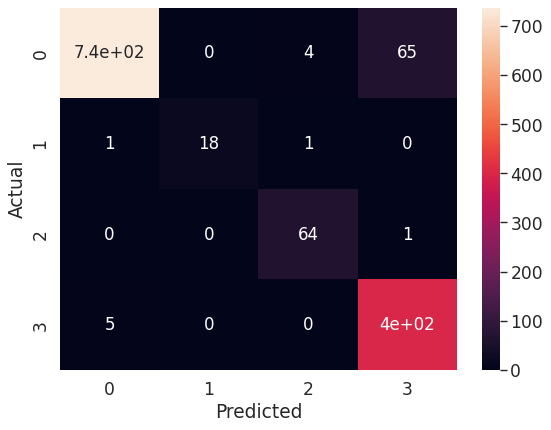

2
microsoft/deberta-base
validation data -> 2: ['Form10k_61', 'Form10k_22', 'Form10k_14', 'Form10k_23'] 


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
output/deberta-basemodel_2021_11_10-03:43:13_AM/deberta-base_e1_v0.041_fold2.pth


100%|██████████| 162/162 [00:06<00:00, 26.62it/s]


,fold,f1_weighted,vallosses
0,1.0,0.941,0.184
1,2.0,0.941,0.199


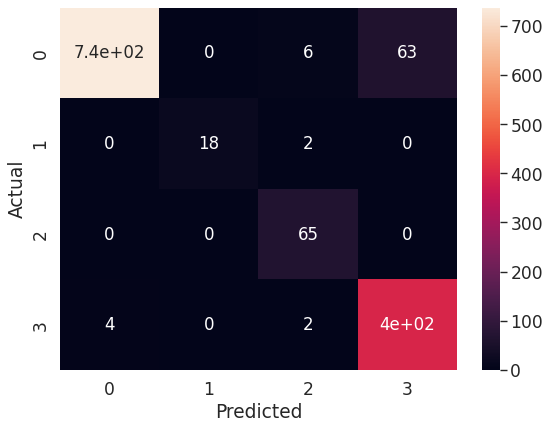

3
microsoft/deberta-base
validation data -> 3: ['Form10k_63', 'Form10k_25', 'Form10k_34', 'Form10k_37'] 


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

added new token:  ['[NSEP]']
['[NSEP]'] 4 1.5e-05
output/deberta-basemodel_2021_11_10-03:43:13_AM/deberta-base_e1_v0.058_fold3.pth


100%|██████████| 162/162 [00:06<00:00, 23.42it/s]


,fold,f1_weighted,vallosses
0,1.0,0.941,0.184
1,2.0,0.941,0.199
2,3.0,0.835,0.510


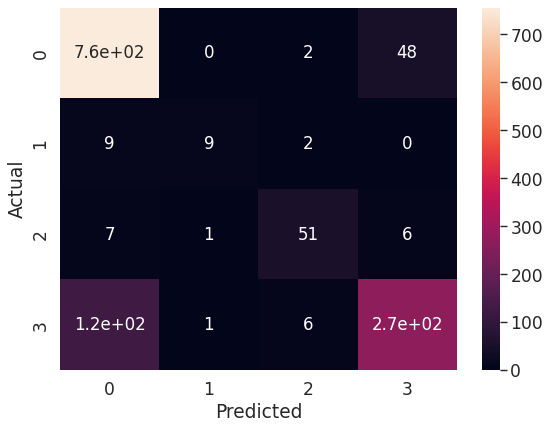

In [9]:
# VAL
bestrecords=pd.DataFrame(columns=["fold","f1_weighted","vallosses"])
_,valdata =loadData(fold)
for fold in CV_DICT.keys():
    print(fold)
    print(MODEL_NAME)
    print(f'validation data -> {fold}: {CV_DICT[fold]} ')
    
    tokenizer,model,optimizer= loadmodel(MODEL_NAME,specialtoken=SEPCIAL_TOKEN)
    modelpath =list(glob.glob(MODELPATH_R+"/"+"*fold{}.pth".format(fold)))[0]
    print(modelpath)
    checkpoint = torch.load(modelpath)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    model.eval()
    

    
    if DEBUG:
        MAX_LEN =400
        val_params = {'batch_size': VALID_BATCH_SIZE,
                        'num_workers': 0
                     }
        valdata=valdata[:DEBUG_DATA_SIZE]
    else:
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        val_params = {'batch_size': VALID_BATCH_SIZE,
                        'num_workers': 0,
                      'collate_fn':data_collator
                        }
    trainset = CustomDataset(valdata, tokenizer, MAX_LEN)
    
    test_dataloader=DataLoader(trainset,**val_params)
    del modelpath,checkpoint
    torch.cuda.empty_cache()
    
    logitsoutput=[]
    batchtargets=[]
    batchoutputs=[]
    batchloss=[]
    
    with torch.no_grad():
        for i,batch in enumerate(tqdm(test_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss,logits=outputs[:2]
            logitsoutput.extend(logits.cpu().detach().numpy())
            
            targets=batch['labels'].cpu().detach().numpy()
            batchtargets.extend(targets)
            
            if USE_AML:
                batchloss.append(loss.item()/ACCUMULATION_STEPS)
            else:
                batchloss.append(loss.item())

            outputs=logits.cpu().detach().numpy()    
            outputs=np.argmax(outputs, axis=1)
            batchoutputs.extend(outputs)
            
    f1_socre= round(f1_score(batchtargets, batchoutputs, average='weighted'),3)        
    loss=round(np.mean(batchloss),3)       
    valdata[f'logits{fold}_f{f1_socre}_v{loss}']=logitsoutput
    valdata[f'targets{fold}']=batchtargets
    valdata[f'predictions{fold}']=test[f'logits{fold}'].apply(lambda x:x.argmax())
    valdata[f'confidence{fold}']=test[f'logits{fold}'].apply(lambda x:np.array([torch.sigmoid(torch.tensor(i)).numpy()*100 for i in x ]))
    
    bestrecords=bestrecords.append({'fold': int(fold),
                                'f1_weighted': f1_socre,
                                'vallosses':loss,
                               },
                               ignore_index=True)   
    display(bestrecords)
    doconfusion_matrix_one(batchtargets,batchoutputs)         
    

    del model,optimizer
    _= gc.collect()
    torch.cuda.empty_cache()
torch.save(valdata,f"{MODEL_NAME.split('/')[-1]}_Valpreds.pkl")
valdata.to_csv(f"{MODEL_NAME.split('/')[-1]}_Testpreds.tsv", sep="\t",index=False)


In [10]:
valdata

### Testdata